# Chapter 14: The Zen of Testing

Paolo Perrotta, Programming Machine Learning: From Coding to Deep Learning (2020)

## The Threat of Overfitting

In [1]:
# The MNIST data loader that we used so far.
# It includes a training and a test set, but no validation set.

import numpy as np
import gzip
import struct


def load_images(filename):
    # Open and unzip the file of images:
    with gzip.open(filename, 'rb') as f:
        # Read the header information into a bunch of variables:
        _ignored, n_images, columns, rows = struct.unpack('>IIII', f.read(16))
        # Read all the pixels into a NumPy array:
        all_pixels = np.frombuffer(f.read(), dtype=np.uint8)
        # Reshape the pixels into a matrix where each line is an image:
        return all_pixels.reshape(n_images, columns * rows)
    
    
def standardize(training_set, test_set):
    average = np.average(training_set)
    standard_deviation = np.std(training_set)
    training_set_standardized = (training_set - average) / standard_deviation
    test_set_standardized = (test_set - average) / standard_deviation
    return (training_set_standardized, test_set_standardized)


# 60000 images, each 785 elements (1 bias + 28 * 28 pixels)
X_train = load_images("./mnist/train-images-idx3-ubyte.gz") #注意檔案路徑是否正確

# 10000 images, each 785 elements, with the same structure as X_train
X_test = load_images("./mnist/t10k-images-idx3-ubyte.gz") #注意檔案路徑是否正確

X_train, X_test = standardize(X_train, X_test)

def load_labels(filename):
    # Open and unzip the file of images:
    with gzip.open(filename, 'rb') as f:
        # Skip the header bytes:
        f.read(8)
        # Read all the labels into a list:
        all_labels = f.read()
        # Reshape the list of labels into a one-column matrix:
        return np.frombuffer(all_labels, dtype=np.uint8).reshape(-1, 1)


def one_hot_encode(Y):
    n_labels = Y.shape[0]
    n_classes = 10
    encoded_Y = np.zeros((n_labels, n_classes))
    for i in range(n_labels):
        label = Y[i]
        encoded_Y[i][label] = 1
    return encoded_Y


# 60K labels, each a single digit from 0 to 9
Y_train_unencoded = load_labels("./mnist/train-labels-idx1-ubyte.gz") #注意檔案路徑是否正確

# 60K labels, each consisting of 10 one-hot encoded elements
Y_train = one_hot_encode(Y_train_unencoded)

# 10000 labels, each a single digit from 0 to 9
Y_test = load_labels("./mnist/t10k-labels-idx1-ubyte.gz") #注意檔案路徑是否正確

In [2]:
print(X_train.shape)

(60000, 784)


In [3]:
# The neural network, with the train() function hacked to provide
# histories of the loss and the accuracy on both the training set
# and the test set.


def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def ReLU(x):
    return np.maximum(0, x)


def softmax(logits):
    exponentials = np.exp(logits)
    return exponentials / np.sum(exponentials, axis=1).reshape(-1, 1)


def sigmoid_gradient(sigmoid):
    return np.multiply(sigmoid, (1 - sigmoid))


def prepend_bias(X):
    return np.insert(X, 0, 1, axis=1)


def Dropout(y, ratio):
    yd = np.zeros(y.size)    
    num = round(y.size*(1-ratio))
    idx = np.random.choice(y.size, num, replace=False)
    yd[idx] = 1.0 / (1.0 - ratio)
    yd=np.reshape(yd,(y.shape))   
    return yd


def initialize_weights(n_input_variables, n_hidden_nodes, n_classes):
    np.random.seed(1234)

    w1_rows = n_input_variables + 1
    w1 = np.random.randn(w1_rows, n_hidden_nodes) * np.sqrt(1 / w1_rows)

    w2_rows = n_hidden_nodes + 1
    w2 = np.random.randn(w2_rows, n_classes) * np.sqrt(1 / w2_rows)
    return (w1, w2)


def forward(X, w1, w2):
    a  = np.matmul(prepend_bias(X), w1)     # (5 x 26) x (26 x 20) = 5 x 20
    h1 = ReLU(a)                         # 5 x 20
    h1 = h1 * Dropout(h1, 0.2)
    b  = np.matmul(prepend_bias(h1), w2)    # (5 x 21) x (21 x 20) = 5 x 20
    y_hat = softmax(b)
    return y_hat, h1, a, b

In [4]:
# This is a test
n_input_variables = X_train.shape[1]
n_classes = Y_train.shape[1]
n_hidden_nodes = 50
w1, w2 = initialize_weights(n_input_variables, n_hidden_nodes, n_classes)
y_hat, h1, a, b = forward(X_train, w1, w2)
print(h1.shape)
print(y_hat.shape)

(60000, 50)
(60000, 10)


In [5]:
def back(X, Y, y_hat, w1, w2, a, b, h1):
    dw2 = np.matmul(prepend_bias(h1).T, y_hat-Y)/X.shape[0]
    dh1 = np.matmul(y_hat - Y, w2[1:].T)
    da  = dh1 * (h1 > 0)
    dw1 = np.matmul(prepend_bias(X).T, da)/X.shape[0]
    return dw1, dw2


def classify(X, w1, w2):
    y_hat, _, _, _ = forward(X, w1, w2)
    labels = np.argmax(y_hat, axis=1)
    return labels.reshape(-1, 1)


def accuracy(X, Y_unencoded, w1, w2):
    return np.average(classify(X, w1, w2) == Y_unencoded) * 100.0


# This loss() takes different parameters than the ones in other source files
def loss(Y, y_hat):
    return -np.sum(Y * np.log(y_hat)) / Y.shape[0]


# This train() stores the loss on both the training and the test sets at each
# step. A the end, it returns those histories to the caller.
# Different from train() functions in other source files, it expects that
# _both_ Y_train and Y_test are one hot encoded.
def train(X_train, Y_train, X_test, Y_test, n_hidden_nodes, iterations, lr):
    n_input_variables = X_train.shape[1]
    n_classes = Y_train.shape[1]
    w1, w2 = initialize_weights(n_input_variables, n_hidden_nodes, n_classes)
    training_losses = []
    test_losses = []
    for i in range(iterations):
        y_hat_train, h1, a, b = forward(X_train, w1, w2)
        y_hat_test, _, _, _ = forward(X_test, w1, w2)
        w1_gradient, w2_gradient = back(X_train, Y_train, y_hat_train, w1, w2, a, b, h1)
        w1 = w1 - (w1_gradient * lr)
        w2 = w2 - (w2_gradient * lr)

        training_loss = -np.sum(Y_train * np.log(y_hat_train)) / Y_train.shape[0]
        training_losses.append(training_loss)
        test_loss = -np.sum(Y_test * np.log(y_hat_test)) / Y_test.shape[0]
        test_losses.append(test_loss)
        if i % 100 == 0:
            print("%5d > Training loss: %.5f - Test loss: %.5f" % (i, training_loss, test_loss))
    return (training_losses, test_losses, w1, w2)

In [6]:
training_losses, test_losses, w1, w2 = train(X_train,Y_train, X_test, one_hot_encode(Y_test),
                                             n_hidden_nodes=50,
                                             iterations=2000,
                                             lr=0.01)

training_accuracy = accuracy(X_train, Y_train_unencoded, w1, w2)
test_accuracy = accuracy(X_test, Y_test, w1, w2)
print("Training accuracy: %.2f%%, Test accuracy: %.2f%%" %
      (training_accuracy, test_accuracy))

    0 > Training loss: 2.55528 - Test loss: 2.54970
  100 > Training loss: 1.03213 - Test loss: 1.01938
  200 > Training loss: 0.74561 - Test loss: 0.72525
  300 > Training loss: 0.62991 - Test loss: 0.60774
  400 > Training loss: 0.56200 - Test loss: 0.54265
  500 > Training loss: 0.52122 - Test loss: 0.50603
  600 > Training loss: 0.48831 - Test loss: 0.47232
  700 > Training loss: 0.46629 - Test loss: 0.44579
  800 > Training loss: 0.44648 - Test loss: 0.43076
  900 > Training loss: 0.43065 - Test loss: 0.41323
 1000 > Training loss: 0.41523 - Test loss: 0.39667
 1100 > Training loss: 0.40213 - Test loss: 0.38626
 1200 > Training loss: 0.39177 - Test loss: 0.38037
 1300 > Training loss: 0.38192 - Test loss: 0.36813
 1400 > Training loss: 0.37503 - Test loss: 0.36169
 1500 > Training loss: 0.36561 - Test loss: 0.35264
 1600 > Training loss: 0.35661 - Test loss: 0.35414
 1700 > Training loss: 0.35252 - Test loss: 0.33916
 1800 > Training loss: 0.34492 - Test loss: 0.33527
 1900 > Trai

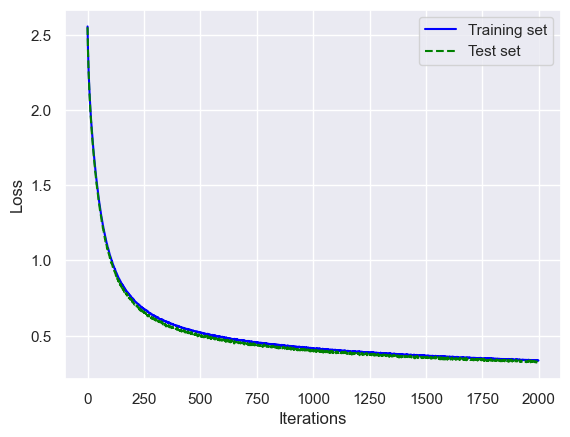

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plt.plot(training_losses, label='Training set', color='blue', linestyle='-')
plt.plot(test_losses, label='Test set', color='green', linestyle='--')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## A Testing Conundrum

In [9]:
# X_train/X_validation/X_test: 60K/5K/5K images
# Each image has 784 elements (28 * 28 pixels)
X_train = load_images("./mnist/train-images-idx3-ubyte.gz") #注意檔案路徑是否正確
X_test_all = load_images("./mnist/t10k-images-idx3-ubyte.gz") #注意檔案路徑是否正確
X_validation, X_test = np.split(X_test_all, 2)

In [10]:
X_train.shape

(60000, 784)

In [11]:
X_validation.shape

(5000, 784)

In [12]:
X_test.shape

(5000, 784)

In [13]:
# 60K labels, each a single digit from 0 to 9
Y_train_unencoded = load_labels("./mnist/train-labels-idx1-ubyte.gz") #注意檔案路徑是否正確

# Y_train: 60K labels, each consisting of 10 one-hot encoded elements
Y_train = one_hot_encode(Y_train_unencoded)

# Y_validation/Y_test: 5K/5K labels, each a single digit from 0 to 9
Y_test_all = load_labels("./mnist/t10k-labels-idx1-ubyte.gz") #注意檔案路徑是否正確
Y_validation, Y_test = np.split(Y_test_all, 2)

In [14]:
Y_train.shape

(60000, 10)

In [15]:
Y_validation.shape

(5000, 1)

In [16]:
Y_test.shape

(5000, 1)